# Prototyping Code for Flight Path Vizualizer

## 1. Loading OpenSky Data

This requires you to actively have credentials to access the Opensky DataBase, please check the [wiki page](https://github.com/Andrerg01/FlightPathAnalysis/wiki/Basic-OpenSky-Data-Usage) for more informaiton

### 1.1 Downloading Flights Information Data

This method allows you to download information about all flights withing a certain date range given an origin airport and a destination airport. 

Please refer to the [List of airports by IATA airport code](https://en.wikipedia.org/wiki/List_of_airports_by_IATA_airport_code:_A) for the precise IATA code of all airports.

The result is given as a pandas dataframe, containing 4 columns of interest (among some more)
 - firstseen: The UNIX UTC time the aircraft was first seen
 - lastseen: The UNIC UTC time the aircraft was last seen
 - icao24: The icao24 identification nunber of the airfract
 - callsign: The callsign of the aircraft for the current flight, providing information about the airline and flight number

In [128]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors


# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
# Checking if credentials file is specified, and if so, loading it.
credentials_file = config['base-configs']['opensky-credentials']
if not credentials_file:
    raise ValueError('No OpenSky credentials file specified in in config.yaml')

with open(f'{root_path}/{credentials_file}', 'r') as file:
    try:
        credentials = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

credentials['hostname'] = config['data-gather']['flights']['hostname']
credentials['port'] = config['data-gather']['flights']['port']
# credentials['bad_days_csv'] = config['data-gather']['flights']['bad-days-csv']
credentials['bad_days_csv'] = f'{root_path}/data/example/flight/example_bad_days.csv'
credentials['chunk_size'] = config['data-gather']['flights']['chunk-size']
credentials['flight_data_timeout'] = config['data-gather']['flights']['flight-data-timeout']
credentials['state_vector_timeout'] = config['data-gather']['flights']['flight-data-timeout']
credentials['flight_data_retries'] = config['data-gather']['flights']['flight-data-retries']
credentials['state_vector_retries'] = config['data-gather']['flights']['flight-data-retries']

# Creates an instance of a logger class to log all that happens, optional (but encouraged) for querying.
logger = utils.Logger(config)
# Creates an instane of the Querier class used for querying the opensky database
opensky_querier = opensky_query.Querier(
    credentials,
    logger = logger)

# Looking at all flights from Baton Rouge to Dallas from `Jan 1, 2022` to `Jan 7, 2022`
departure_airport = 'KBTR'
arrival_airport = 'KDFW'
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 1, 2)

# This code will query the database and return the flights requested.
# As mentioned in the wiki, sometimes there are missing files for some days, which the code handles and adds as an exception before repeating the query
flights = opensky_querier.query_flight_data(
          {'departure_airport': departure_airport,
          'arrival_airport': arrival_airport}, 
          {'start': start_date, 
          'end': end_date})

flights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023/10/17 08:53:36 : Querying data for flights from KBTR to KDFW between the dates 2021-12-31 HH:MM:SS and 2022-01-01 HH:MM:SS
2023/10/17 08:53:58 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641081600
    ORDER BY firstseen;
2023/10/17 08:54:21 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641081600
    ORDER BY firstseen;


,firstseen,lastseen,callsign,icao24,estdepartureairport,estarrivalairport,day
0,1641047161,1641051233,SKW3125,a99b5f,KBTR,KDFW,1640995200
1,1641061714,1641065878,ENY3536,a8dbbd,KBTR,KDFW,1640995200
2,1641089450,1641093689,SKW3185,a972be,KBTR,KDFW,1641081600
3,1641125850,1641130088,SKW3125,a992cf,KBTR,KDFW,1641081600
4,1641147684,1641151763,ENY3536,a81db0,KBTR,KDFW,1641081600
5,1641160980,1641165650,N527RY,a6a47d,KBTR,KDFW,1641081600


### 1.2 Downloading a Flight's State Vectors

This example code shows you how to download the flight's state vectors given one of the entries of the flights dataframe above.

It returns 5 columns of interest:
 - time: Recorded Unix UTC time of when the data was gathered
 - lat: Latitude of the aircraft at the given time
 - lon: Longitude of the aircraft at the given time
 - baroaltitude: Altitude of the aircraft according to the internal barometer at the given time
 - geoaltitude: Altitude of the aircraft according to the internal gps at the given time


2023/10/13 15:33:13 : Querying data for statevectors for ICAO24 a81db0 between the times 2022-01-02 and 2022-01-02
2023/10/13 15:33:15 : Querying: SELECT time, lat, lon, velocity, heading, baroaltitude, geoaltitude, onground, hour
    FROM state_vectors_data4
    WHERE icao24 = 'a81db0' 
    AND (time >= 1641147684 AND time <= 1641151763)
    AND (hour > 1641144084 AND hour < 1641155363)
    ORDER BY time;


,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,onground,hour
2,1.641148e+09,30.540456,-91.140051,84.506725,42.039064,76.20,76.20,false,1.641146e+09
3,1.641148e+09,30.541573,-91.138843,84.889495,41.806551,99.06,68.58,false,1.641146e+09
4,1.641148e+09,30.542272,-91.138129,84.889495,41.806551,106.68,68.58,false,1.641146e+09
5,1.641148e+09,30.542504,-91.137909,85.659174,41.347777,121.92,106.68,false,1.641146e+09
6,1.641148e+09,30.543549,-91.136870,86.434247,40.897203,137.16,129.54,false,1.641146e+09
...,...,...,...,...,...,...,...,...,...
4067,1.641152e+09,32.874252,-96.976813,70.585766,316.181189,205.74,312.42,false,1.641150e+09
4068,1.641152e+09,32.874911,-96.977552,70.585766,316.181189,198.12,312.42,false,1.641150e+09
4069,1.641152e+09,32.875168,-96.977856,70.585766,316.181189,198.12,312.42,false,1.641150e+09
4072,1.641152e+09,32.876450,-96.979340,70.215481,315.890536,190.50,289.56,false,1.641150e+09


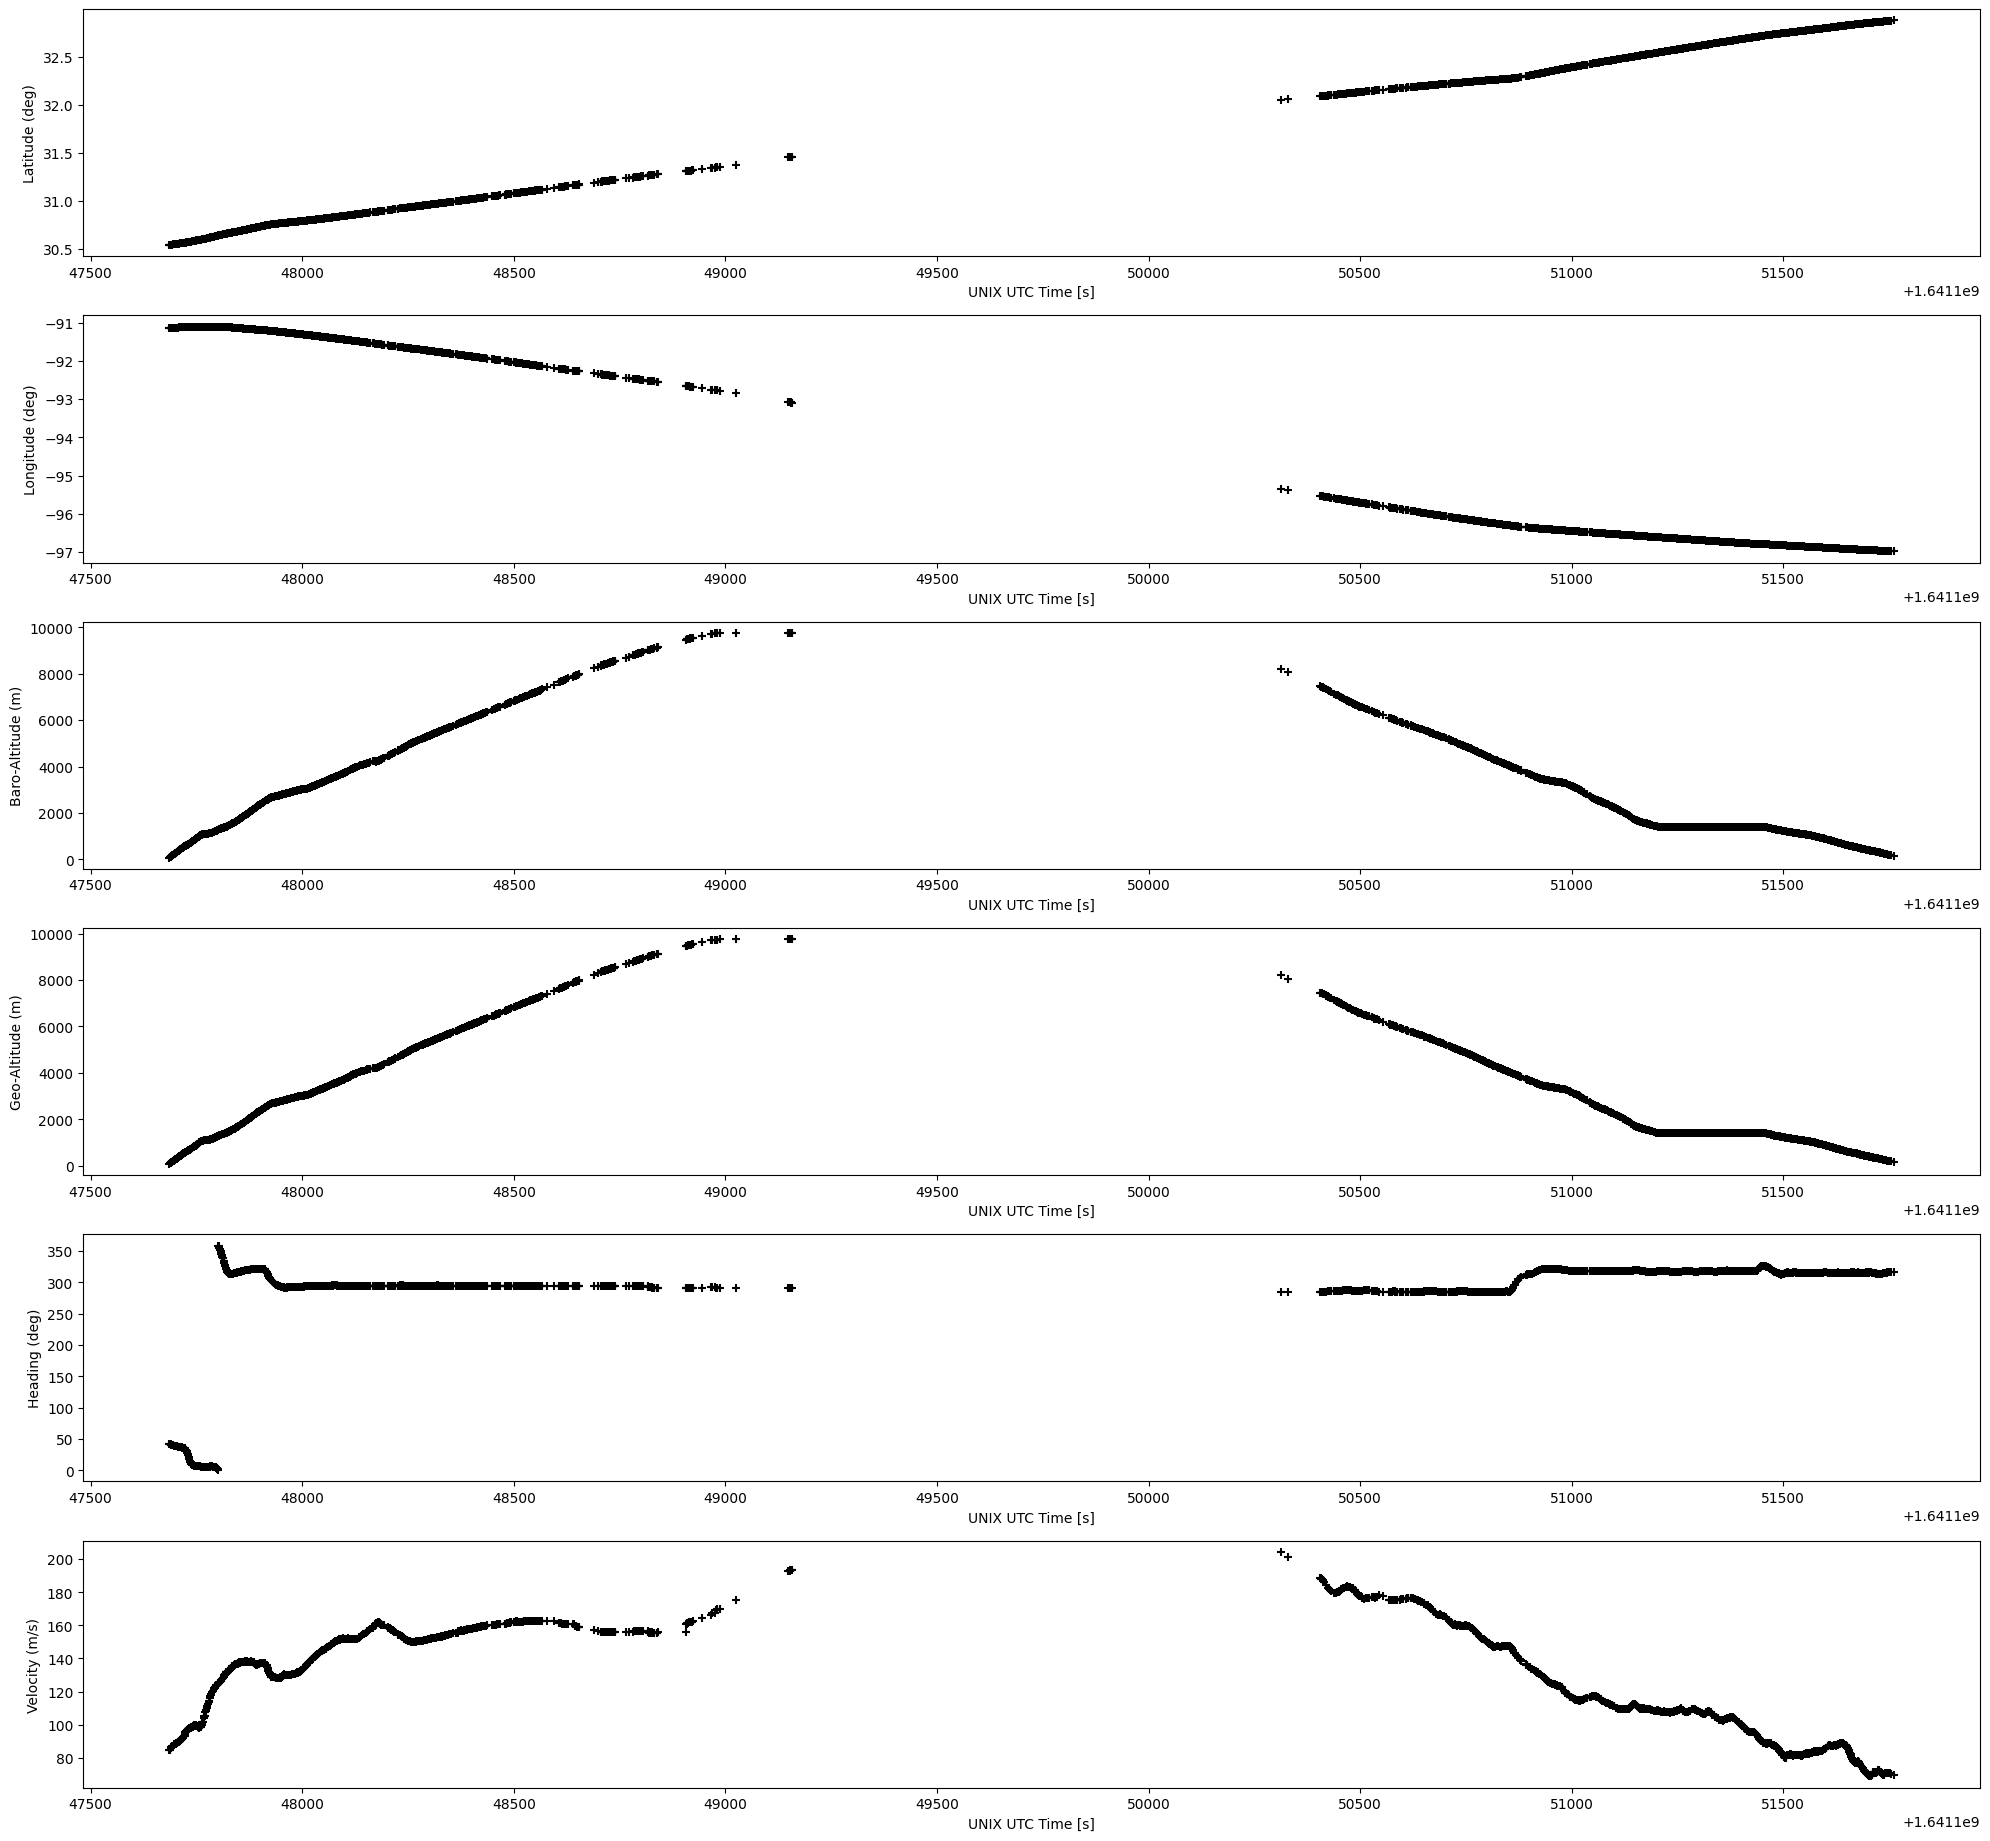

In [6]:
import numpy as np

# Let's choose a random flight out of the dataframe we got
flight = flights.sample(1).iloc[0]

# Similarly to querying flight data, there are 'bad hours' which can happen
state_vectors = opensky_querier.query_state_vectors(
                flight['icao24'],
                flight['firstseen'],
                flight['lastseen'])

# Checks if no sneaky strings make it into the rows
cols_to_check = ['time', 'lat', 'lon', 'velocity', 'heading', 'baroaltitude', 'geoaltitude', 'hour']
for col in cols_to_check:
    state_vectors[col] = state_vectors[col].apply(lambda x: np.nan if isinstance(x, str) else x)
state_vectors.dropna(inplace=True)

# This drops identical columns. If OpenSky does not have the data for some time, it just fills it with the previous (or sometimes future) datapoint, we don't want that, so we check to see if a row's lat and lon is repeated (that is, if the aircraft did not move), then we clean it.
cols_to_check = ['lat', 'lon']
state_vectors = state_vectors.drop_duplicates(subset=cols_to_check, keep='first')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

state_vectors.to_csv(f'{root_path}/data/example/flight/state_vectors_example.csv')

state_vectors

In [12]:
datetime.timedelta(weeks = 1).total_seconds()

604800.0

## 2. Compressing and Decompressing State Vector Data

This section covers the algorithms used to compress and decompress the state vector data. Beware that most of these are lossy processes. It's meant to capture the shape of each of the variables in the statevector, while minimizing the amount of data necessary for storage.


### 2.1 Spline Compressor

**Description:**

This method computes the *Optimal Spline* that captures the data, and saves the values associated to it in order to reconstruct it at a later time.

**Method:**

The first step is to normalize all the data between 0 and 1 but re-ranging it: $x -> (x - xmin)/(xmax - xmin)$.

Each curve of interest for each flight will be converted to a spline. The precision $s$ (s = 0 -> maximum precision) will be determined such that the spline will be the one that results with the smallest total length of coefficients and knots while minimizing s, and still passes the pearson correlation threshold against the original data.

Note: a small s will result in a better precision, but also more coefficients.
Note on the algorithm: 
 - First find the largest `s` that still passes the threshold
 - Thne find the smallest `s` that does not present a higher complexity (len(knots) + len(coeffs))
 
The information of the coefficients, knots, minimum and maxium of all variables is stored and used to reconstruct the original spline and data.

**Caveats:**

Sometimes it produces weird features due to the polynomial interpolation which are not in agreement with the actual data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Compression Factor: 35.12670713201821


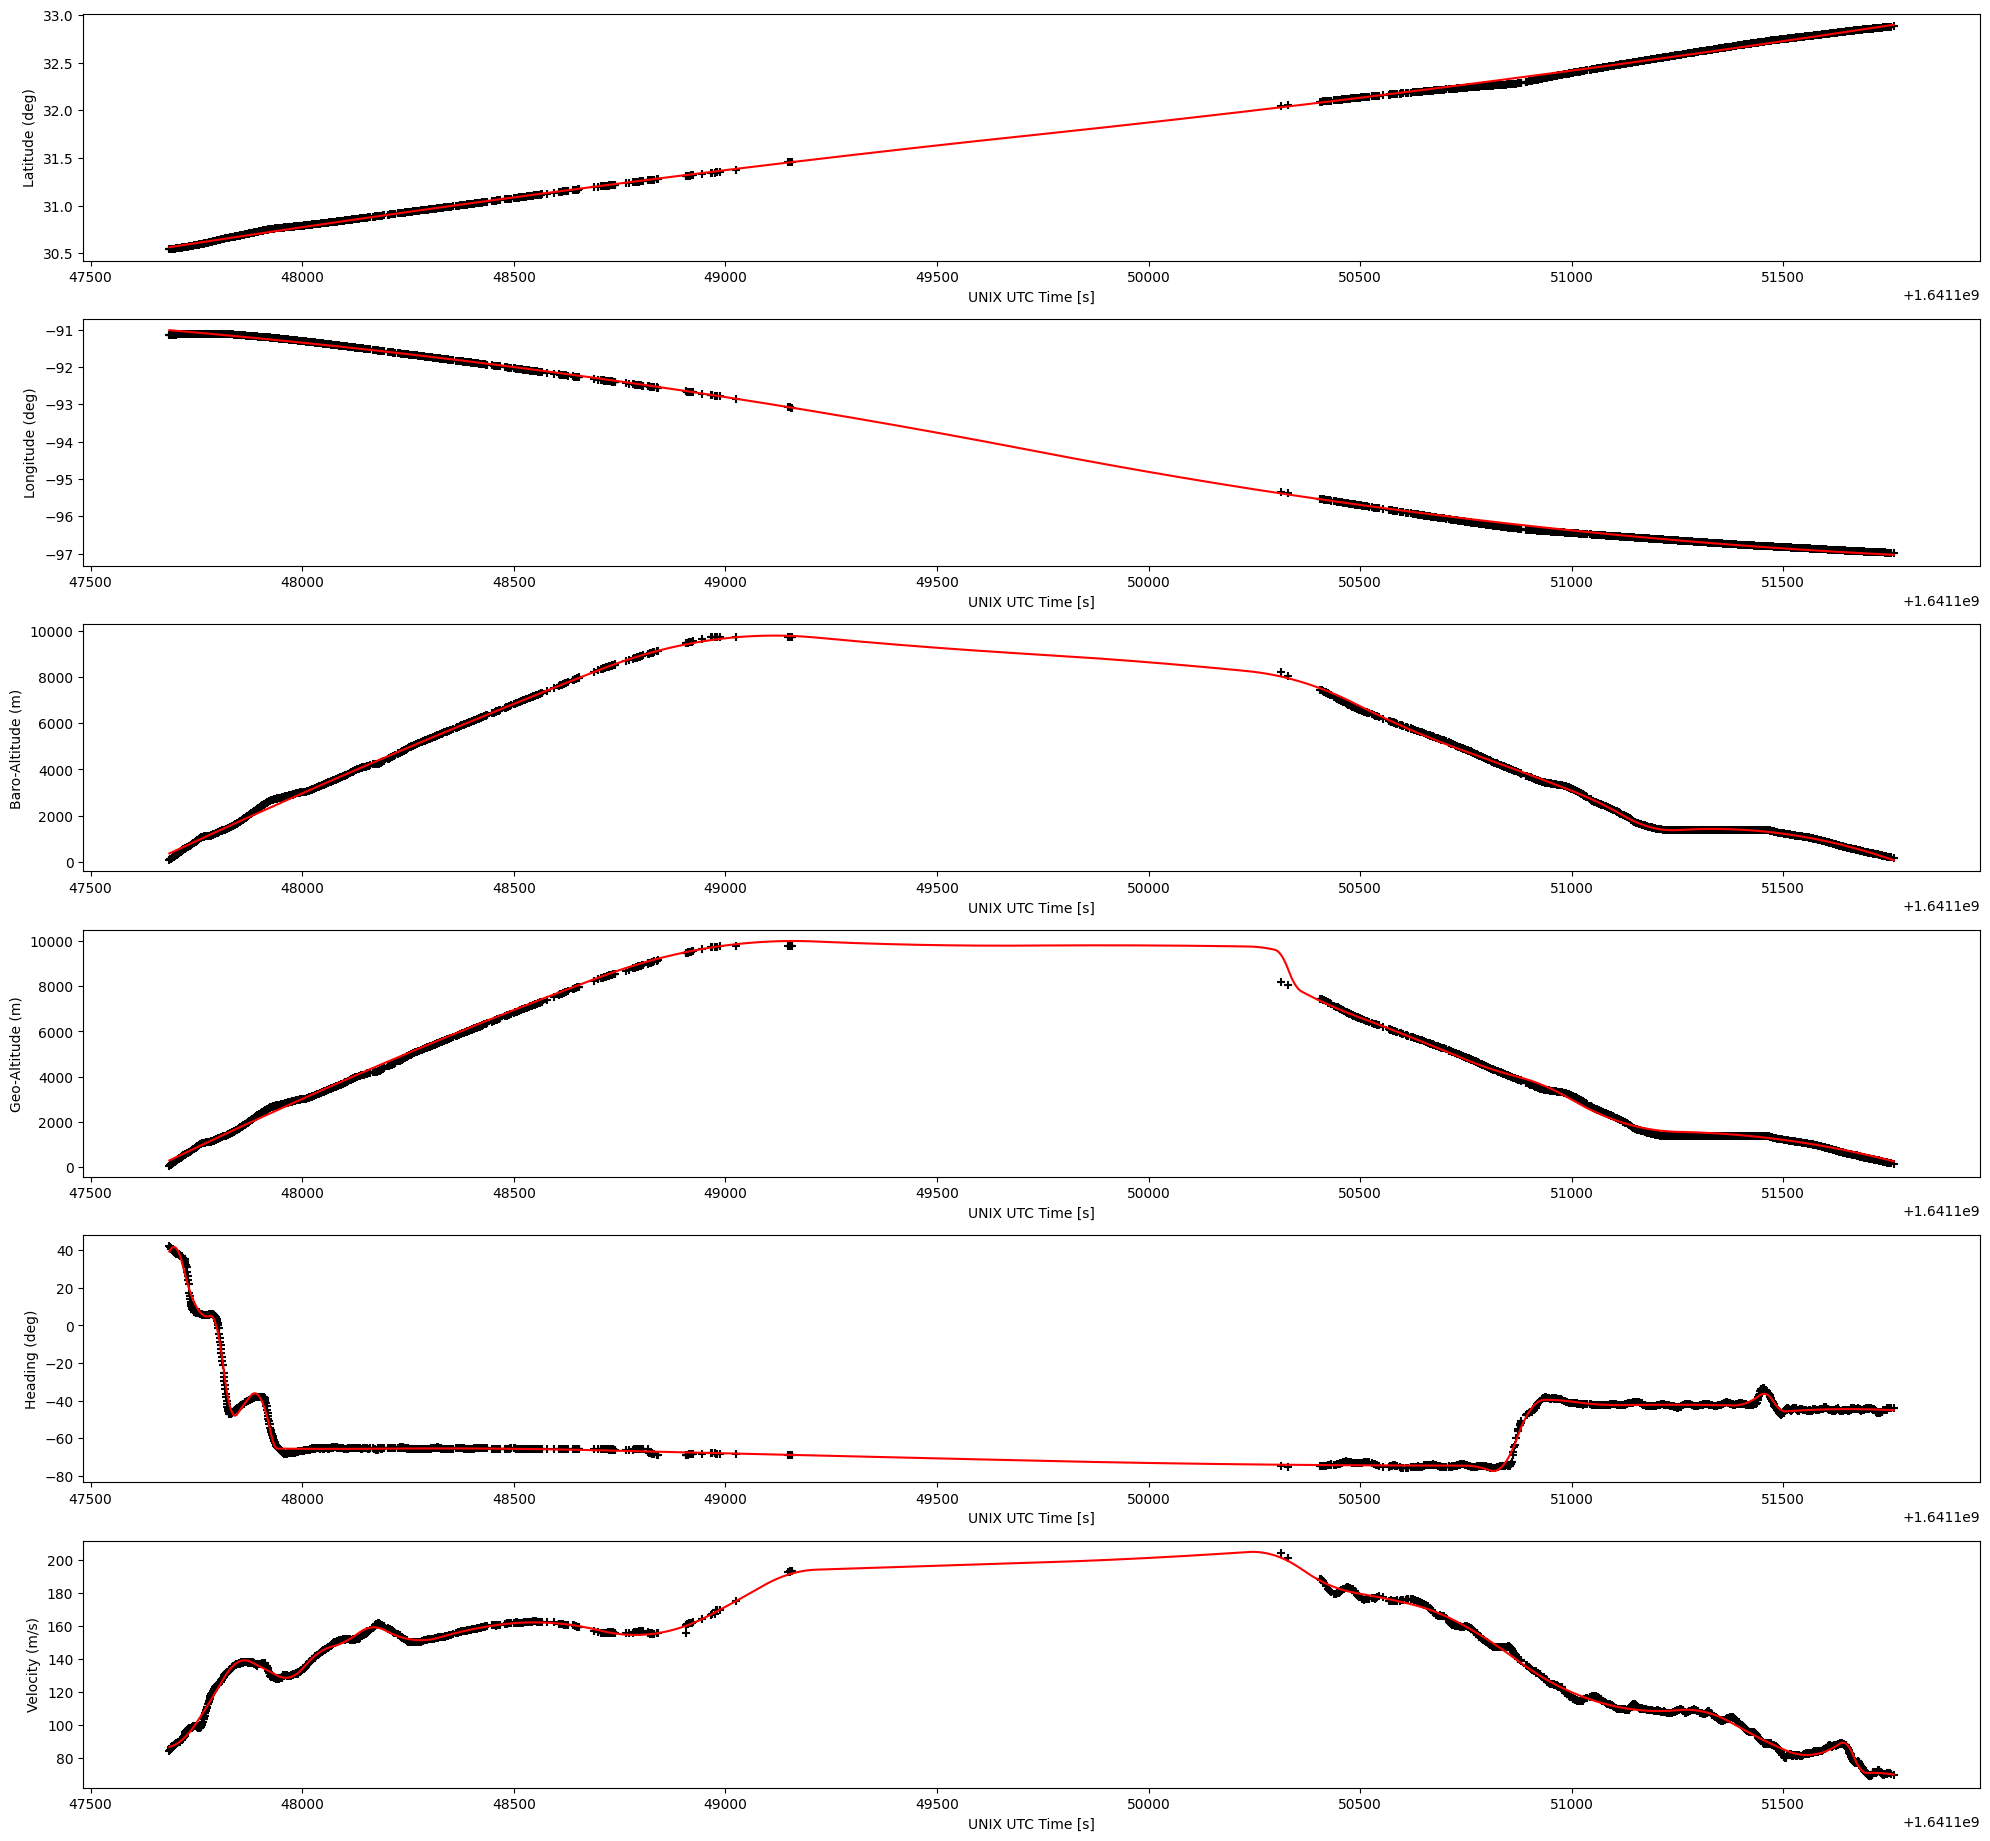

In [69]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import pandas as pd
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# Loading state vectos from csv, not needed if you just ran the steps above
state_vectors = pd.read_csv(f'{root_path}/data/example/flight/state_vectors_example.csv', index_col=0)

# Creates an instance of the SplineCompressor class.
compressor = compressors.SplineCompressor(config)

# List of columns of state_vectors to be compressed.
columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
# This method encodes the information from the columns into a dictionary, which can be used to recreate the data upon request.
metadata = compressor.encode_from_dataframe(state_vectors, 'time', columns)
# Computes the compression factor achieved as x_old/x_new.
compression_factor = compressor.compute_compression_factor(state_vectors['time'].values, state_vectors[columns].values, metadata)
print(f"Compression Factor: {compression_factor}")
# Turns dictionary data into the yaml format
yaml_data = yaml.dump(metadata, default_flow_style=None)
# Saves it to a yaml file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'w') as f:
    f.write(yaml_data)
    
# We can now retrive the yaml file and reconstruct it
# From here we load the config file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'r') as file:
    try:
        metadata = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# This can then be saved to a yml file, it can be recovered from the method below (for now it just supports one column at a time)
# It returns a function for which an input x can be given and it will output the corresponding reconstructed data
spline_lat = compressor.decode_spline_single_column(metadata, 'lat')
spline_lon = compressor.decode_spline_single_column(metadata, 'lon')
spline_balt = compressor.decode_spline_single_column(metadata, 'baroaltitude')
spline_galt = compressor.decode_spline_single_column(metadata, 'geoaltitude')
spline_head = compressor.decode_spline_single_column(metadata, 'heading')
spline_vel = compressor.decode_spline_single_column(metadata, 'velocity')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
x = np.linspace(metadata['lat']['xmin'], metadata['lat']['xmax'], num = 1000)

# y_lat = np.interp(x, state_vectors['time'].values, state_vectors['lat'].values)
# y_lon = np.interp(x, state_vectors['time'].values, state_vectors['lon'].values)
# y_balt = np.interp(x, state_vectors['time'].values, state_vectors['baroaltitude'].values)
y_lat = spline_lat(x)
y_lon = spline_lon(x)
y_balt = spline_balt(x)
y_galt = spline_galt(x)
y_head = spline_head(x)
y_vel = spline_vel(x)

ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].plot(x, y_lat, color = 'red')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].plot(x, y_lon, color = 'red')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].plot(x, y_balt, color = 'red')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].plot(x, y_galt, color = 'red')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].plot(x, y_head, color = 'red')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].plot(x, y_vel, color = 'red')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

### 2.2 CSV Compressor

**Description:**

This method works by using simple linear interpolating the state vector data through a set number of points, and saving those points for future interpolation

**Method:**

The number of points to be saved in the csv file is set by the `num-points` parameter in the `csv-compressor` section on the `config.yml` file.
The data is then interpolated in regular intervals between the minimum and maximum valid times and those points are saved as ana dequate representation of the data.

**Caveats:**

In [71]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import pandas as pd
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

# TO-Do

# 3. Plotting and Finding Flight Paths

This part is still ongoing, I have not done serious coding for the steps below, only the steps above

## 3.1 Loading compressed flight data for a single flight, recreating spline, and recreating data.

Note, this requires the existence of at least one `csv` file containig the flight's state vectors. If there's none, you can download an example dataset from [here](https://drive.google.com/drive/folders/13pp3z1NJYthXFBbyc2x76djZ2SfPZwS8?usp=sharing) (Remember to unzip it)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


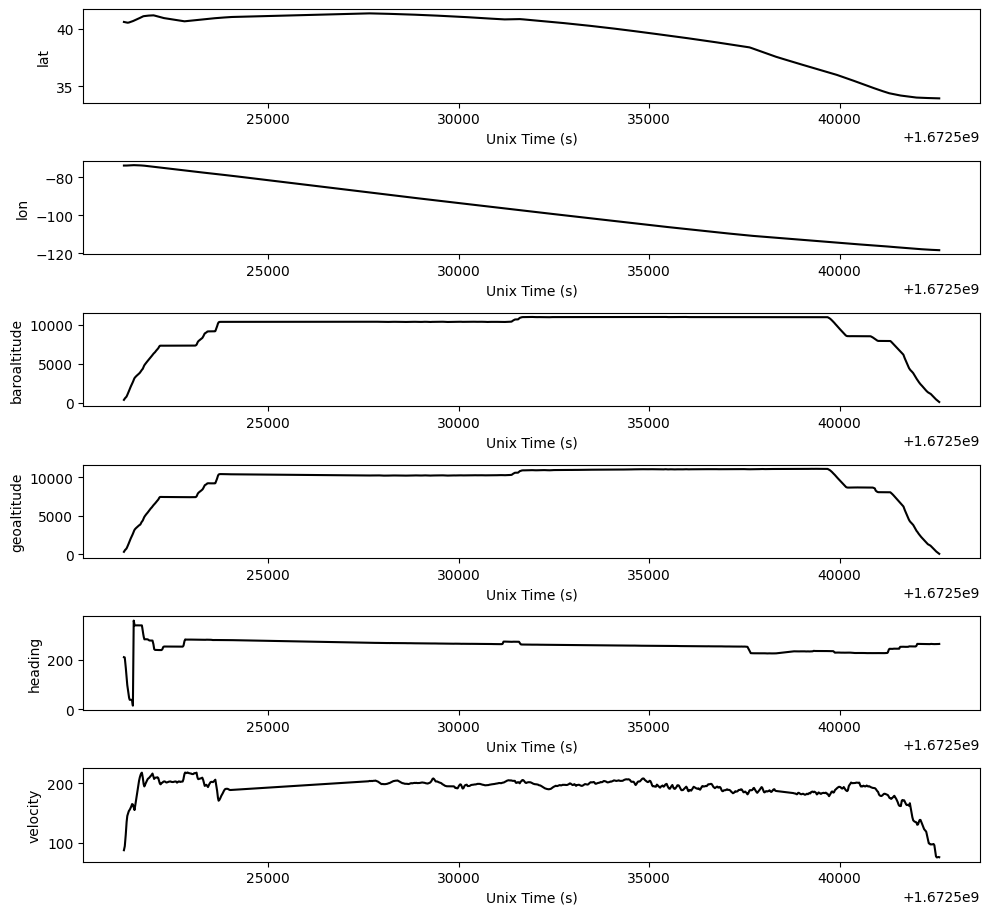

In [130]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_directory = '../data/flight/KJFK_KLAX/'
filename = 'a00d5b_1672521217_1672542615_KJFK_KLAX.csv'

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']

compressor = compressors.CsvCompressor(config)
df = compressor.decode_to_dataframe_from_file(f'{data_directory}/state_vectors/{filename}')

fig, ax = plt.subplots(len(columns), figsize = [10, 15/1.62])
for i, col in enumerate(columns):
    ax[i].plot(df['time'], df[col], color = 'k')
    ax[i].set_xlabel('Unix Time (s)')
    ax[i].set_ylabel(f'{col}')
    
fig.tight_layout()

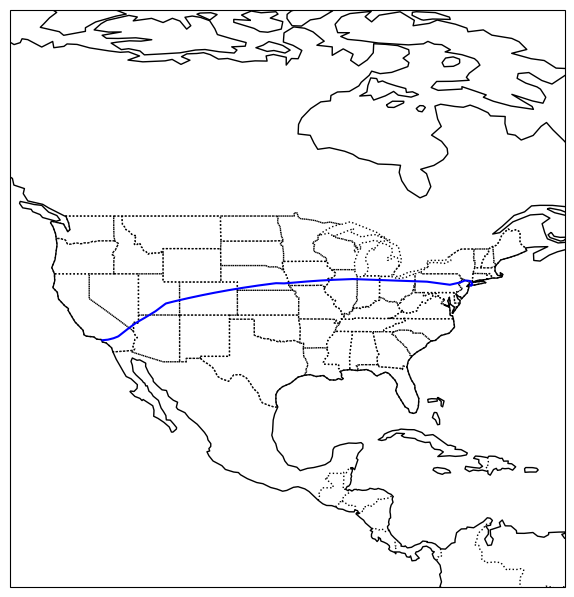

In [131]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = [7.5, 7.5])
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

range_lat = max(df['lat']) - min(df['lat'])
range_lon = max(df['lon']) - min(df['lon'])
RANGE = max([range_lon, range_lat])*1.5
mid_lat = (max(df['lat']) + min(df['lat']))/2
mid_lon = (max(df['lon']) + min(df['lon']))/2
extent = [mid_lon - RANGE/2, mid_lon + RANGE/2, mid_lat - RANGE/2, mid_lat + RANGE/2]
ax.set_extent(extent)

# ax.plot(ys['lat'], ys['lon'], marker='o', color='blue', markersize=5, label='City', linestyle='-', transform=ccrs.Geodetic())
ax.plot(df['lon'], df['lat'], color='blue', transform=ccrs.PlateCarree())


## 3.2 Loading compressed flight data for many flights, recreating splines, and recreating data for them all.

Note, this requires the existence of at least two `yml` file containig the flights. If there's none, you can download an example dataset from [here](https://drive.google.com/drive/folders/13pp3z1NJYthXFBbyc2x76djZ2SfPZwS8?usp=sharing) (Remember to unzip it)

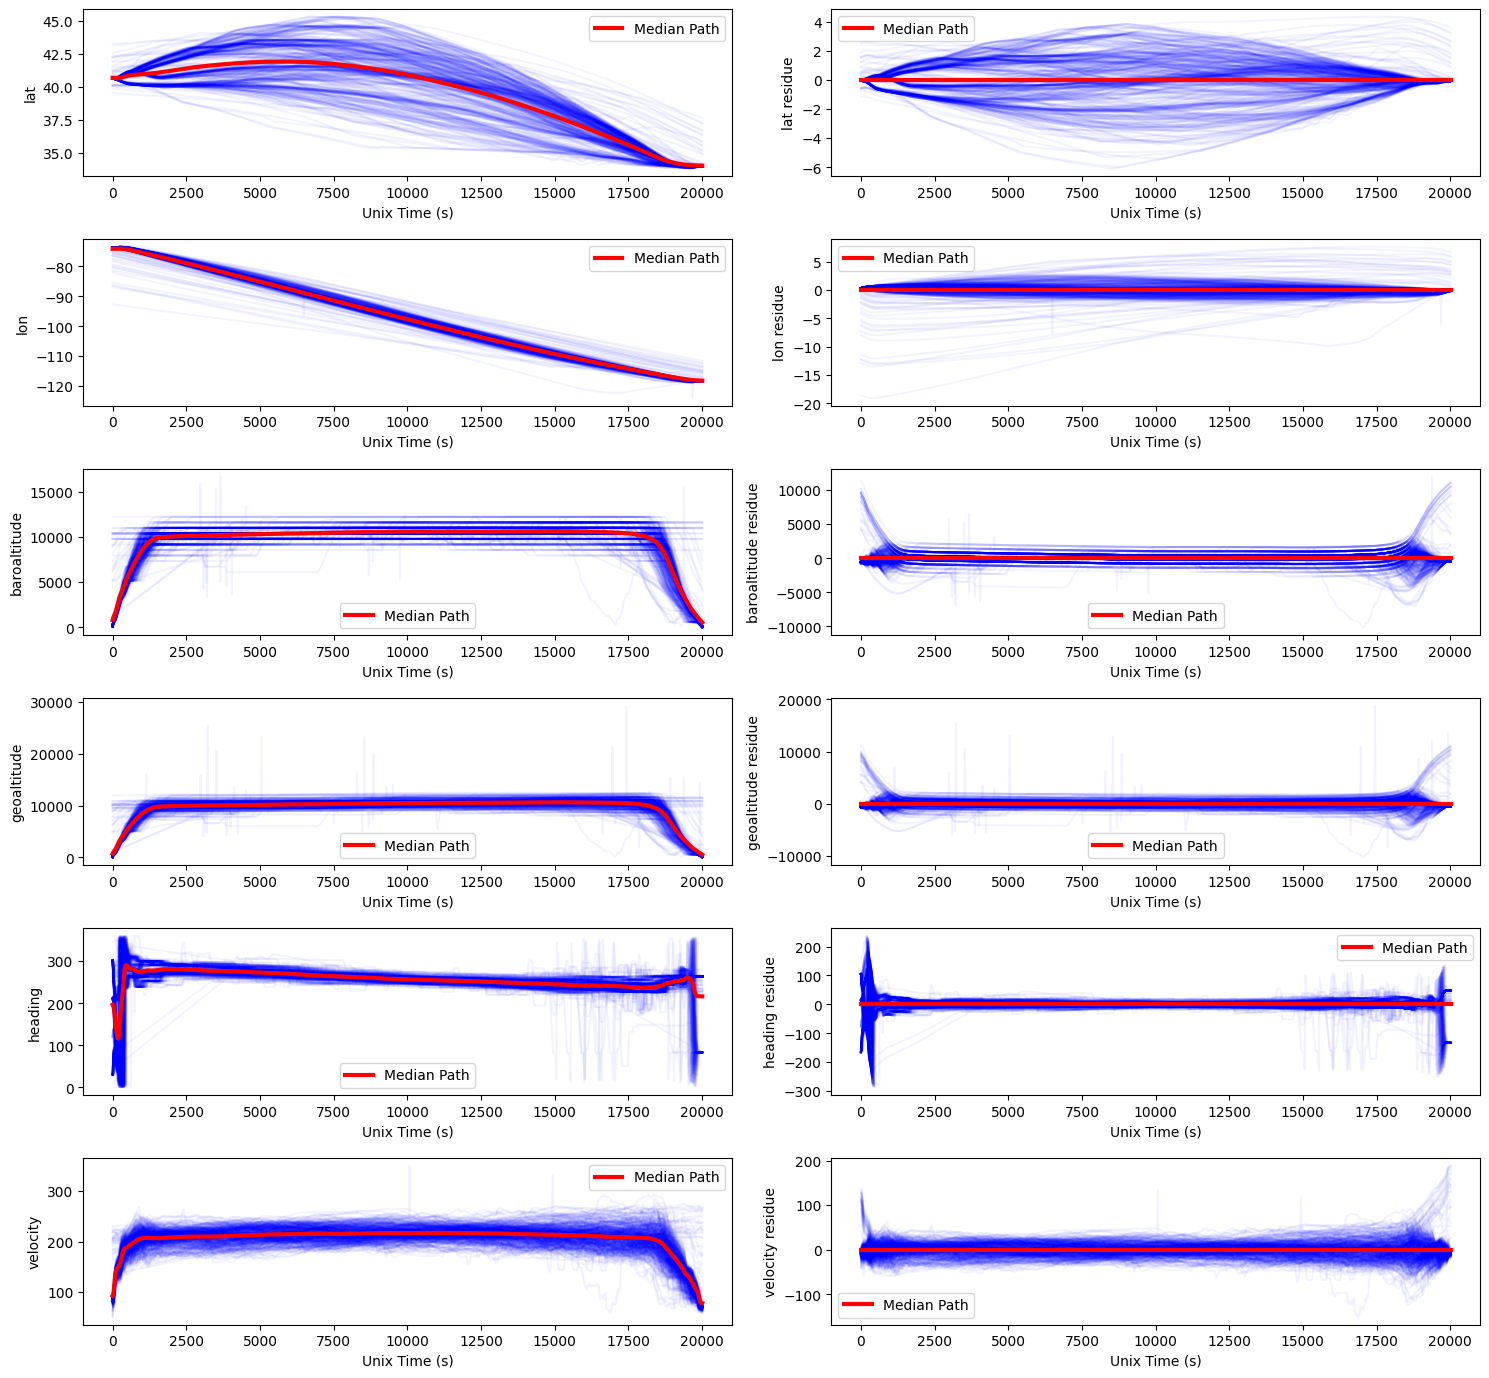

In [134]:
import os
files = [f'{f}' for f in os.listdir(f'{data_directory}/state_vectors/') if f.endswith('.csv')]

ys = np.zeros((len(files), len(columns), 1000))
total_ts = np.zeros(len(files))
for i, filename in enumerate(files):
    try:
        df = compressor.decode_to_dataframe_from_file(f'{data_directory}/state_vectors/{filename}')

        df_interp = {col:[] for col in columns}
        df_interp = {'time':np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num = 1000)}
        for j, col in enumerate(columns):
            df_interp[col] = np.interp(df_interp['time'], df['time'], df[col])
            ys[i, j] = df_interp[col].copy()
            if col == 'lat' or col == 'heading':
                ys[i, j] = np.mod(ys[i, j], 360)
        total_ts[i]=df['time'].iloc[-1] - df['time'].iloc[0]
    except:
        for k in range(len(columns)):
            ys[i, k] = np.repeat(np.nan, 1000)
        total_ts[i] = np.nan
mask = ~np.any(np.isnan(ys), axis=(1, 2))
ys = ys[mask]
total_ts = total_ts[~np.isnan(total_ts)]

medians = np.mean(ys, axis=0)
xs = np.linspace(0, np.median(total_ts), num = 1000)

fig, ax = plt.subplots(len(columns), 2, figsize = [15, 22.5/1.62])
for i, col in enumerate(columns):
    for j in range(ys.shape[0]):
        ax[i, 0].plot(xs, ys[j, i], color = 'b', alpha=1/np.sqrt(ys.shape[0]))
        ax[i, 0].set_xlabel('Unix Time (s)')
        ax[i, 0].set_ylabel(f'{col}')
        
        ax[i, 1].plot(xs, ys[j, i] - medians[i], color = 'b', alpha=1/np.sqrt(ys.shape[0]))
        ax[i, 1].set_xlabel('Unix Time (s)')
        ax[i, 1].set_ylabel(f'{col} residue')
        
        
    ax[i, 0].plot(xs, medians[i], color = 'r', label = 'Median Path', linewidth = 3)
    ax[i, 0].legend()
    
    ax[i, 1].plot(xs, medians[i] - medians[i], color = 'r', label = 'Median Path', linewidth = 3)
    ax[i, 1].legend()

fig.tight_layout()

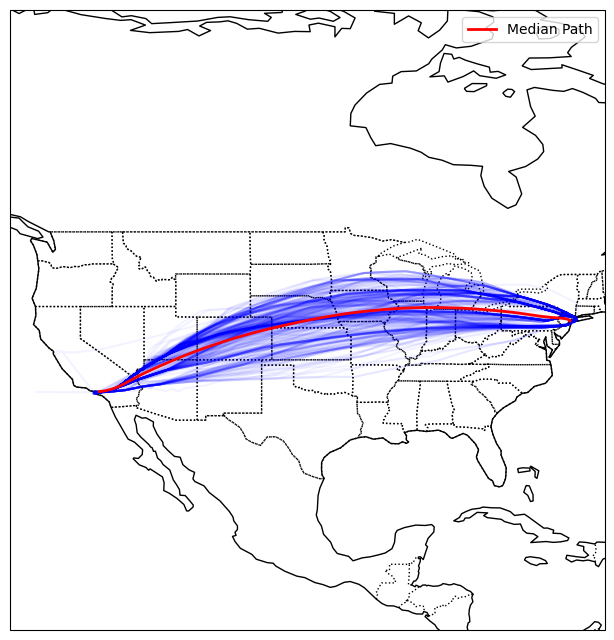

In [135]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = [6.5, 6.5])
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

for i in range(ys.shape[0]):
    ax.plot(ys[i,1,:], ys[i,0,:], color = 'b', alpha=1/np.sqrt(ys.shape[0]))
ax.plot(medians[1], medians[0], color = 'r', linewidth = 2, label = 'Median Path')

x_min, x_max, y_min, y_max = ax.get_extent()
RANGE = np.max([y_max - y_min, x_max - x_min])
y_mid = (y_max + y_min)/2
x_mid = (x_max + x_min)/2
ax.set_extent([x_mid - RANGE/2, x_mid + RANGE/2, y_mid - RANGE/2, y_mid + RANGE/2])

ax.legend()
fig.tight_layout()

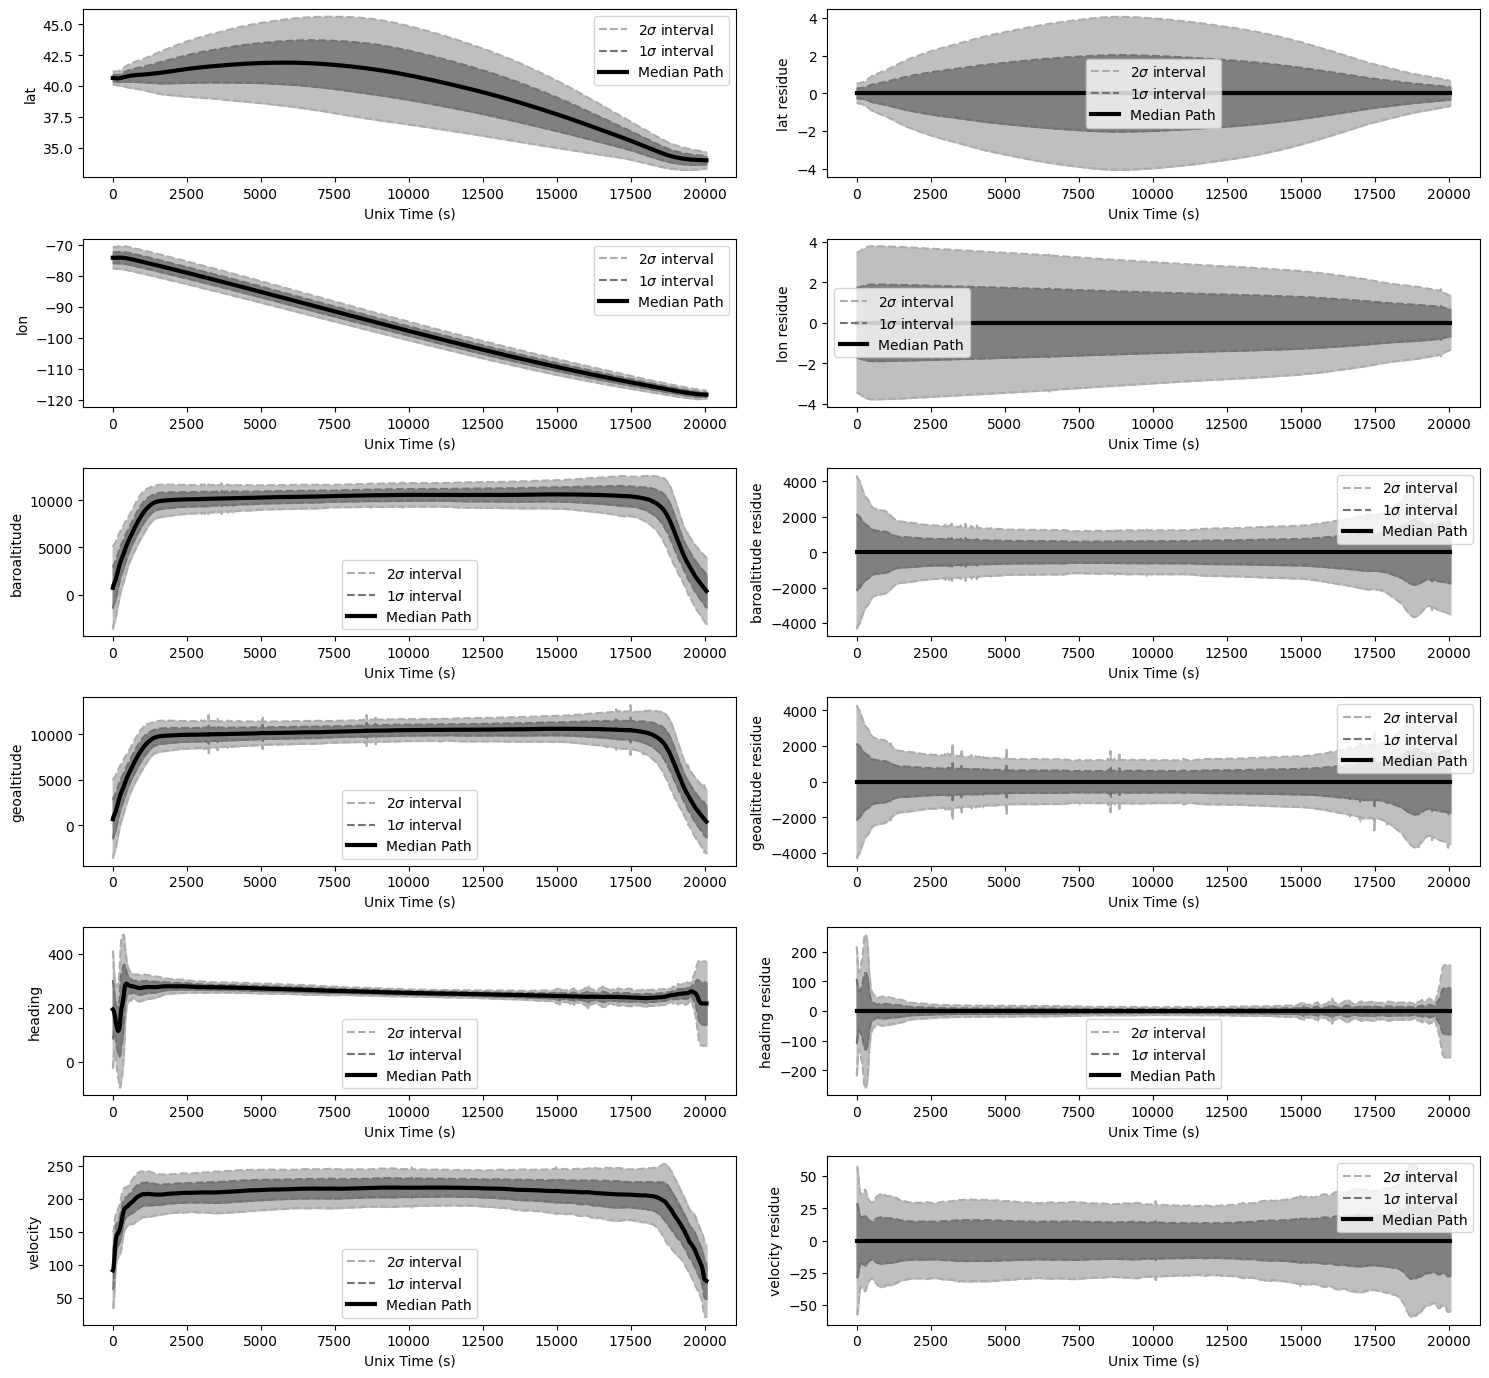

In [50]:
error_measure = 'standard_deviation'

if error_measure == 'percentile':
    percentiles = [50, 90]
    percentile_names = ['50% Interval', '90% Interval']
    percentile_a_up = np.percentile(ys, 50 + percentiles[0]/2, axis = 0)
    percentile_a_lo = np.percentile(ys, 50 - percentiles[0]/2, axis = 0)
    percentile_b_up = np.percentile(ys, 50 + percentiles[1]/2, axis = 0)
    percentile_b_lo = np.percentile(ys, 50 - percentiles[1]/2, axis = 0)
elif error_measure == 'standard_deviation':
    sigmas = [1, 2]
    percentile_names = [r'$1\sigma$ interval', r'$2\sigma$ interval']
    percentile_a_up = medians + sigmas[0]*np.std(ys, axis = 0)
    percentile_a_lo = medians - sigmas[0]*np.std(ys, axis = 0)
    percentile_b_up = medians + sigmas[1]*np.std(ys, axis = 0)
    percentile_b_lo = medians - sigmas[1]*np.std(ys, axis = 0)


xs = np.linspace(0, np.median(total_ts), num = 1000)

color_a = np.array([0.5, 0.5, 0.5])
color_b = np.array([0.75, 0.75, 0.75])
fig, ax = plt.subplots(len(columns), 2, figsize = [15, 22.5/1.62])
for i, col in enumerate(columns):
    ax[i, 0].plot(xs, percentile_b_up[i], '--', color = color_b*.9, label = percentile_names[1])
    ax[i, 0].plot(xs, percentile_b_lo[i], '--', color = color_b*.9)
    ax[i, 0].fill_between(xs, percentile_b_up[i], percentile_b_lo[i], color=color_b)
    
    ax[i, 0].plot(xs, percentile_a_up[i], '--', color = color_a*.9, label = percentile_names[0])
    ax[i, 0].plot(xs, percentile_a_lo[i], '--', color = color_a*.9)
    ax[i, 0].fill_between(xs, percentile_a_up[i], percentile_a_lo[i], color=color_a)
    
    ax[i, 0].plot(xs, medians[i], color = 'k', label = 'Median Path', linewidth = 3)
    ax[i, 0].legend()
    ax[i, 0].set_xlabel('Unix Time (s)')
    ax[i, 0].set_ylabel(f'{col}')

    ax[i, 1].plot(xs, percentile_b_up[i] - medians[i], '--', color = color_b*.9, label = percentile_names[1])
    ax[i, 1].plot(xs, percentile_b_lo[i] - medians[i], '--', color = color_b*.9)
    ax[i, 1].fill_between(xs, percentile_b_up[i] - medians[i], percentile_b_lo[i] - medians[i], color=color_b)
    
    ax[i, 1].plot(xs, percentile_a_up[i] - medians[i], '--', color = color_a*.9, label = percentile_names[0])
    ax[i, 1].plot(xs, percentile_a_lo[i] - medians[i], '--', color = color_a*.9)
    ax[i, 1].fill_between(xs, percentile_a_up[i] - medians[i], percentile_a_lo[i] - medians[i], color=color_a)
    
    ax[i, 1].plot(xs, medians[i] - medians[i], color = 'k', label = 'Median Path', linewidth = 3)
    ax[i, 1].legend()
    ax[i, 1].set_xlabel('Unix Time (s)')
    ax[i, 1].set_ylabel(f'{col} residue')

fig.tight_layout()

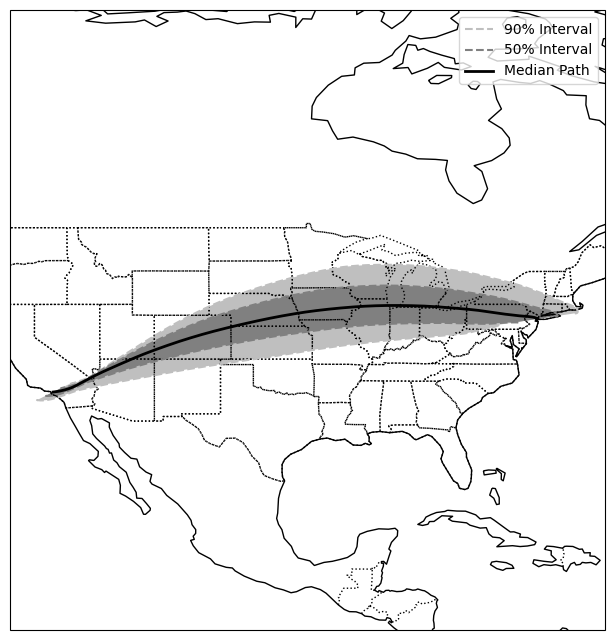

In [51]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[6.5, 6.5])
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.plot(percentile_b_up[1], percentile_b_up[0], '--', color = color_b, label = '90% Interval')
ax.plot(percentile_b_lo[1], percentile_b_lo[0], '--', color = color_b)
x_1, y_1 = percentile_b_up[1], percentile_b_up[0]
x_2, y_2 = percentile_b_lo[1], percentile_b_lo[0]
xy_90up = np.column_stack((x_1, y_1))
xy_90lo = np.column_stack((x_2, y_2))
verts_90p = np.vstack([xy_90up, xy_90lo[::-1]])
poly_90p = Polygon(verts_90p, facecolor=color_b, edgecolor='none')
ax.add_patch(poly_90p)

ax.plot(percentile_a_up[1], percentile_a_up[0], '--', color = color_a, label = '50% Interval')
ax.plot(percentile_a_lo[1], percentile_a_lo[0], '--', color = color_a)
x_1, y_1 = percentile_a_up[1], percentile_a_up[0]
x_2, y_2 = percentile_a_lo[1], percentile_a_lo[0]
xy_50up = np.column_stack((x_1, y_1))
xy_50lo = np.column_stack((x_2, y_2))
verts_50p = np.vstack([xy_50up, xy_50lo[::-1]])
poly_50p = Polygon(verts_50p, facecolor=color_a, edgecolor='none')
ax.add_patch(poly_50p)

ax.plot(medians[1], medians[0], color = 'k', linewidth = 2, label = 'Median Path')

x_min, x_max, y_min, y_max = ax.get_extent()
RANGE = np.max([y_max - y_min, x_max - x_min])
y_mid = (y_max + y_min)/2
x_mid = (x_max + x_min)/2
ax.set_extent([x_mid - RANGE/2, x_mid + RANGE/2, y_mid - RANGE/2, y_mid + RANGE/2])
ax.legend()
fig.tight_layout()

# 4 Testing plotter.py

## 4.1 Plotting Flight Paths and Distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of files: 637


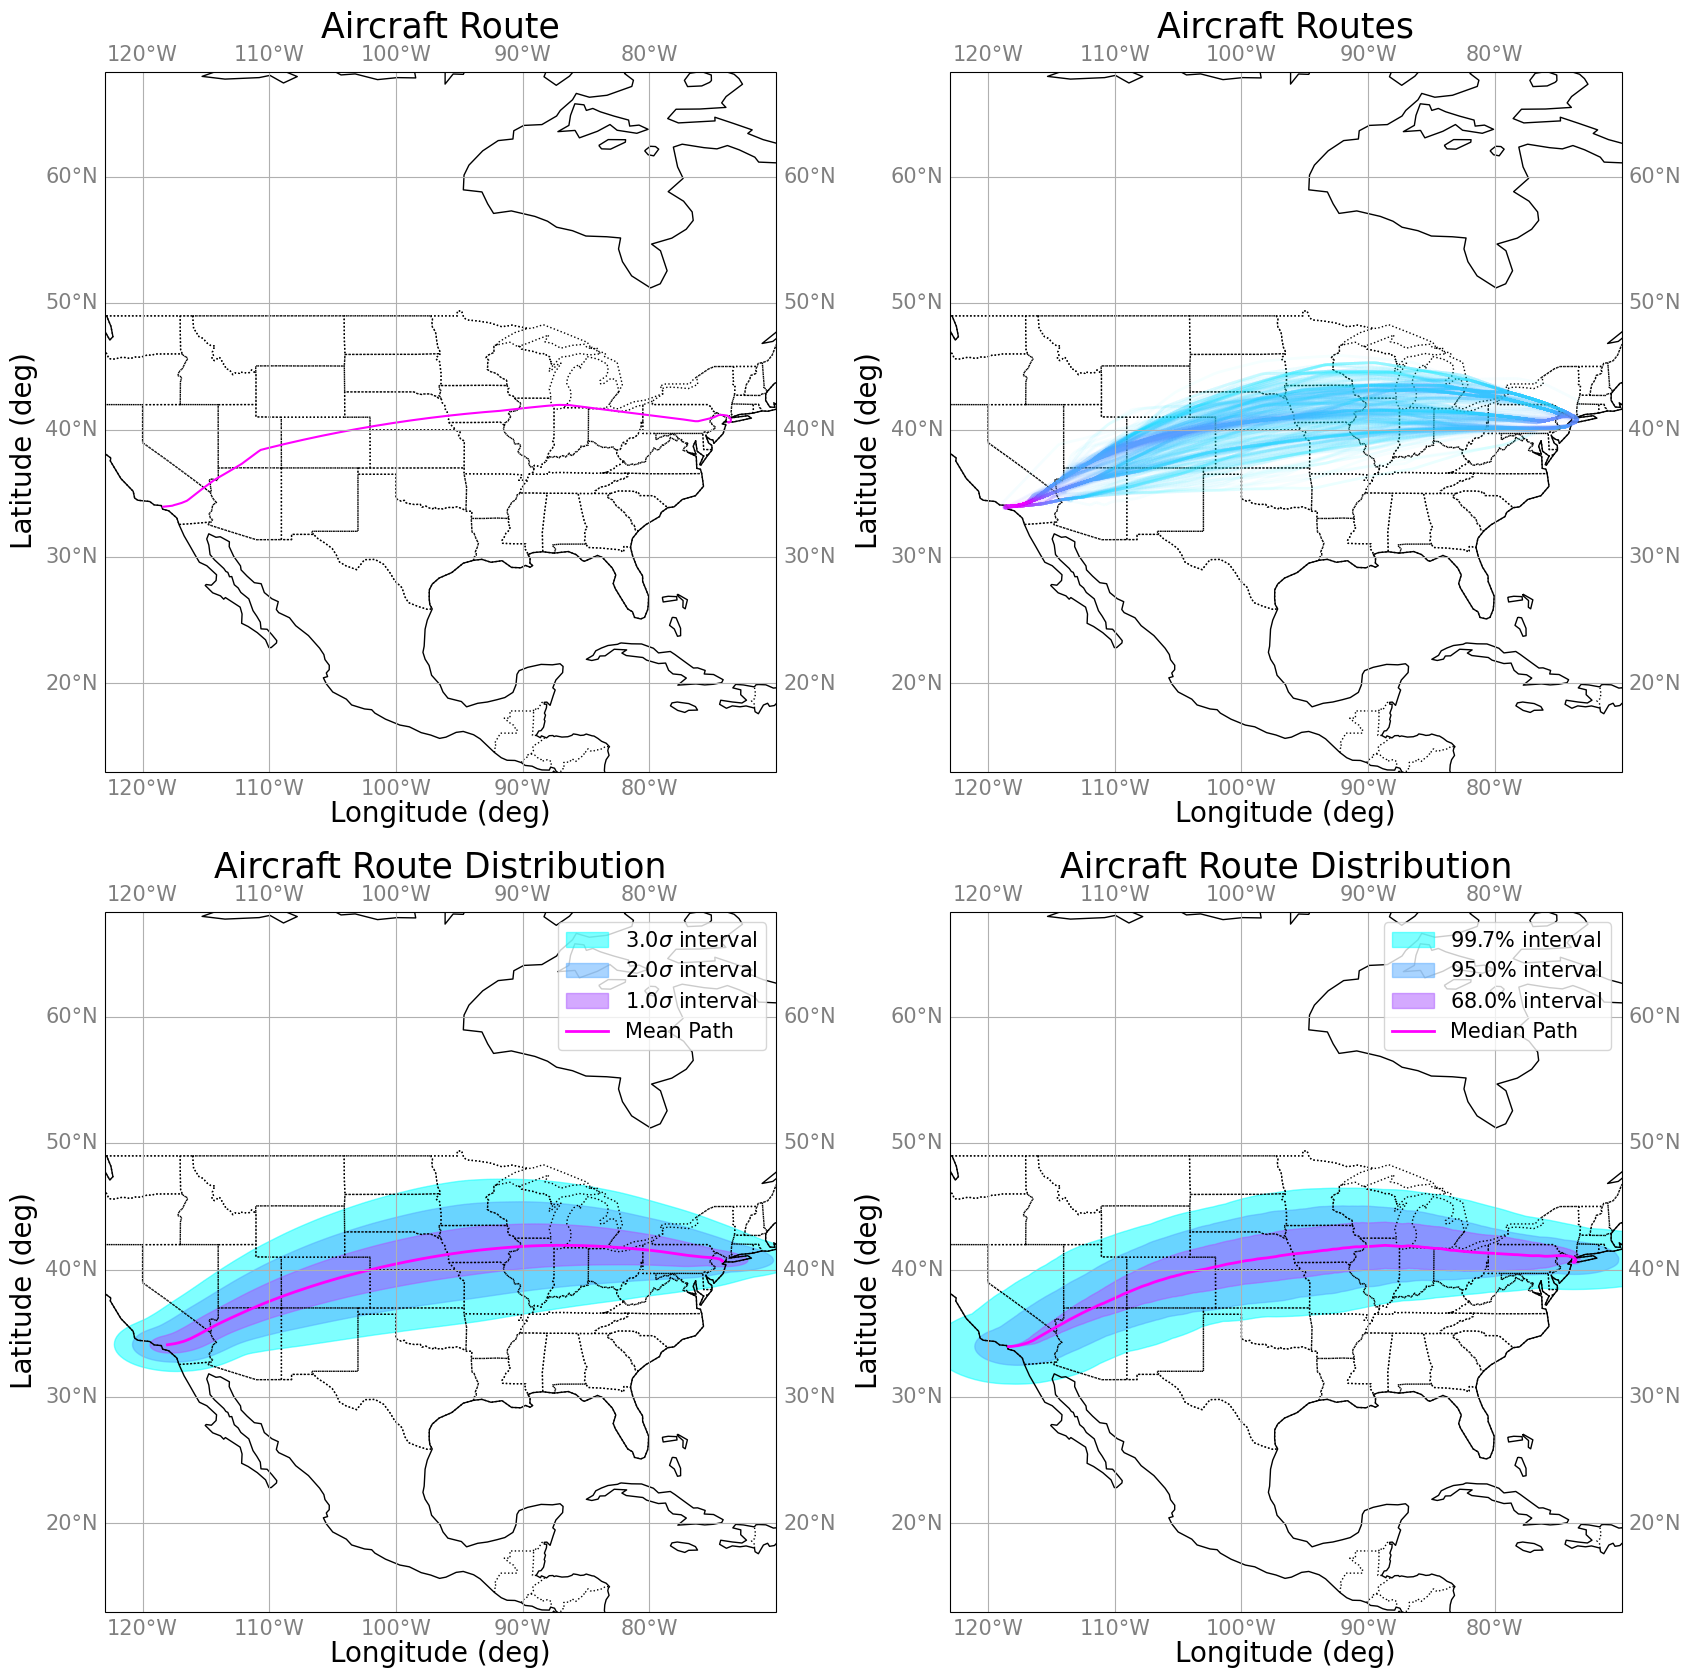

In [32]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors
# Package to generate plot images
from src.frontend import plotter

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_directory = '../data/flight/KJFK_KLAX/'
# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

compressor = compressors.CsvCompressor(config)

pltr = plotter.Plotter(config)

state_vectors_file = [f'{data_directory}/state_vectors/{f}' for f in os.listdir(f'{data_directory}/state_vectors/') if f.endswith('.csv')]

fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20, 20])

pltr.plot_route(state_vectors_file[10], compressor, ax=ax[0, 0])
pltr.plot_multiple_routes(state_vectors_file, compressor, ax=ax[0, 1])
pltr.plot_multiple_routes_shaded(state_vectors_file, compressor, ax=ax[1, 0])

config['plotting']['expectation-measure'] = 'median'
config['plotting']['deviation-measure'] = 'pct'
config['plotting']['deviation-values'] = [68, 95, 99.7]

pltr = plotter.Plotter(config)

pltr.plot_multiple_routes_shaded(state_vectors_file, compressor, ax=ax[1, 1])

print(f'Number of files: {len(state_vectors_file)}')

# 5 Statistical Analysis (Not Complete or working, do not proceed, not a tutorial)

**Description**:

In this step we'll take a look at some interesting statistics for the flight path depending on some hyperparameter of it. We'll look at following causes for different flight paths:
 - Airline
 - Departure time of day
 - Departure day of the week
 
And as the consequence of those causes, we'll be looking at
 - Time of travel
 - Cruising Altitude
 - Cruising Speed
 - Path Length
 - Overall Path

**Method**:

First we'll separate the paths into categories depending on the quantity of cause we're interested in.
Then we'll compute the desided quantities for each flight, then comparing them separated by quantity of cause.

In [41]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
import os
import datetime

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_directory = '../data/flight/'

flight_data_file = 'KJFK_KLAX_2023-01-01_2023-02-01.csv'

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
columns = ['lat', 'lon', 'geoaltitude']


minimum_count = 200

timeseries_length = 100

compressor = compressors.CsvCompressor(config)

# Computing our dependent variables
def get_day_of_week(unix_time):
    dt = datetime.datetime.fromtimestamp(unix_time)
    return dt.strftime('%A')
def get_decimal_hour(unix_time):
    dt = datetime.datetime.fromtimestamp(unix_time)
    hour = dt.hour
    minute = dt.minute
    return hour + minute / 60.0
flight_data = pd.read_csv(f'{data_directory}/{flight_data_file}', index_col = 0)
# Computing Airline for each flight
flight_data['airline'] = [row['callsign'][:3] for i, row in flight_data.iterrows()]
# Computing Day of the Week for each flight
flight_data['weekday'] = flight_data['day'].apply(get_day_of_week)
flight_data['hour_of_day'] = flight_data['firstseen'].apply(get_decimal_hour)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import math
from IPython.display import clear_output

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371e3  # Earth's radius in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c

    return d

def physical_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    surface_distance = haversine_distance(lat1, lon1, lat2, lon2)
    altitude_difference = alt2 - alt1
    distance = math.sqrt(surface_distance**2 + altitude_difference**2)
    
    return distance

# Plotting different airline paths
data_files = [f'{data_directory}/{f}' for f in os.listdir(data_directory) if f.endswith('KJFK_KLAX.csv')]

def compute_time_of_travel(df):
    return df['time'].iloc[-1] - df['time'].iloc[0]

def compute_cruising_altitude(df):
    pc_10 = len(df)//10
    pc_90 = 9*len(df)//10
    return np.mean(df.iloc[pc_10: pc_90]['geoaltitude'].values)

def compute_cruising_speed(df):
    pc_10 = len(df)//10
    pc_90 = 9*len(df)//10
    return np.mean(df.iloc[pc_10: pc_90]['velocity'].values)

def compute_path_length(df):
    total_distance = 0
    for i in range(1, len(df)):
        lat1, lon1, alt1 = df.iloc[i-1][['lat', 'lon', 'geoaltitude']]
        lat2, lon2, alt2 = df.iloc[i][['lat', 'lon', 'geoaltitude']]

        total_distance += physical_distance(lat1, lon1, alt1, lat2, lon2, alt2)
    return total_distance            

flights_info = {'TimeOfTravel':np.repeat(np.nan, len(flight_data)),
                'CruisingAltitude':np.repeat(np.nan, len(flight_data)),
                'CruisingSpeed':np.repeat(np.nan, len(flight_data)),
                'PathLength':np.repeat(np.nan, len(flight_data))
               }
i = 0
for _, row in flight_data.iterrows():
    clear_output(wait=True)
    print(f'{i}/{len(flight_data)}')
    if any(row['icao24'] in filename for filename in data_files):
        for filename in data_files:
            if row['icao24'] in filename:
                df = compressor.decode_to_dataframe_from_file(f'{filename}')
                flights_info['TimeOfTravel'][i] = compute_time_of_travel(df)
                flights_info['CruisingAltitude'][i] = compute_cruising_altitude(df)
                flights_info['CruisingSpeed'][i] = compute_cruising_speed(df)
                flights_info['PathLength'][i] = compute_path_length(df.iloc[0:len(df):1000])
    i += 1

for key in flights_info.keys():
    flight_data[key] = flights_info[key]
flight_data

730/731


,firstseen,lastseen,callsign,icao24,estdepartureairport,estarrivalairport,day,airline,weekday,hour_of_day,TimeOfTravel,CruisingAltitude,CruisingSpeed,PathLength
0,1672511424,1672532270,JBU2223,ad9e73,KJFK,KLAX,1672531200,JBU,Saturday,12.500000,21566.0,10614.594516,191.166889,4.013205e+06
1,1672521217,1672542615,AAL306,a00d5b,KJFK,KLAX,1672531200,AAL,Saturday,15.216667,21397.0,10549.927344,195.164863,3.985028e+06
2,1672526446,1672547757,DAL2801,a12861,KJFK,KLAX,1672531200,DAL,Saturday,16.666667,20924.0,10336.257172,199.911576,3.932859e+06
3,1672526803,1672548126,JBU623,adb723,KJFK,KLAX,1672531200,JBU,Saturday,16.766667,20134.0,10424.505621,222.186766,4.143762e+06
4,1672528901,1672549675,DAL1058,a1775f,KJFK,KLAX,1672531200,DAL,Saturday,17.350000,20770.0,10101.373893,204.919724,3.921983e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1675266900,1675287626,DAL482,a1373d,KJFK,KLAX,1675209600,DAL,Tuesday,9.916667,21121.0,10783.811196,197.611358,4.006495e+06
80,1675268371,1675289313,DAL999,a14c29,KJFK,KLAX,1675209600,DAL,Tuesday,10.316667,19403.0,9846.315355,215.151529,3.963542e+06
81,1675269670,1675290441,AAL331,a03fff,KJFK,KLAX,1675209600,AAL,Tuesday,10.683333,20306.0,10453.710845,215.960506,4.127691e+06
82,1675271769,1675292802,JBU2223,ada5ee,KJFK,KLAX,1675209600,JBU,Tuesday,11.266667,NaN,NaN,NaN,NaN


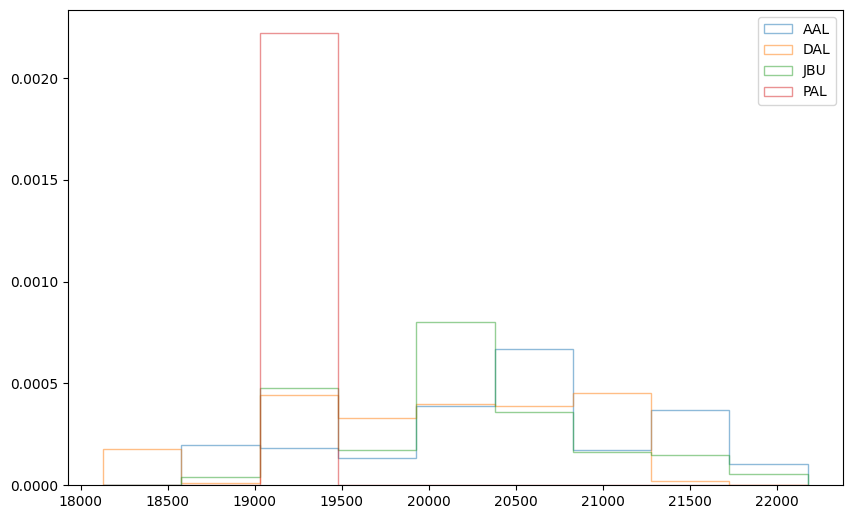

In [40]:
v1 = 'TimeOfTravel'
v2 = 'airline'
flight_data.dropna(inplace=True)

bins = np.linspace(flight_data[v1].min(), flight_data[v1].max(), num=10)
fig, ax = plt.subplots(figsize = [10, 10/1.62])
for value in np.unique(flight_data[v2]):
    ax.hist(flight_data[flight_data[v2] == value][v1], alpha = 0.5, bins = bins, label = value, density=True, histtype='step')
ax.legend()

# 6. Machine Learning

## 6.1 Using tSNE to categorize types of flights

In [75]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

from src.backend import utils

data_directory = utils.clean_path('../data/flight/KJFK_KLAX/')
filename = 'a00d5b_1672521217_1672542615_KJFK_KLAX.csv'

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

compressor = compressors.CsvCompressor(config)

state_vectors_path = os.path.join(data_directory, 'state_vectors')
state_vectors_file = [os.path.join(state_vectors_path, f) for f in os.listdir(state_vectors_path) if f.endswith('.csv')]

columns = ['lon', 'lat', 'heading', 'geoaltitude', 'baroaltitude','velocity']

colormap = getattr(plt.cm, config['plotting']['cmap'])

timeseries_length = 1000
ys = np.zeros((len(state_vectors_file), len(columns)*timeseries_length))
total_ts = np.zeros(len(state_vectors_file))
for i, filename in enumerate(state_vectors_file):
    df_interp = {col:[] for col in columns}
    try:
        df = compressor.decode_to_dataframe_from_file(filename)

        df_interp = {'time':np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num=timeseries_length)}
        for j, col in enumerate(columns):
            df_interp[col] = np.interp(df_interp['time'], df['time'], df[col])
            if col == 'lat' or col == 'heading':
                df_interp[col] = np.mod(df_interp[col], 360)
        df_interp = pd.DataFrame(df_interp)
        total_ts[i]=df['time'].iloc[-1] - df['time'].iloc[0]
        ys[i] = np.ravel(df_interp[columns].values.T)
    except:
        for k in range(len(columns)):
            ys[i] = np.repeat(np.nan, len(columns)*timeseries_length)
        total_ts[i] = np.nan
    
        
ys = ys[~np.any(np.isnan(ys), axis=(1))]
total_ts = total_ts[~np.isnan(total_ts)].reshape(-1, 1)
ys = np.hstack((ys, total_ts))


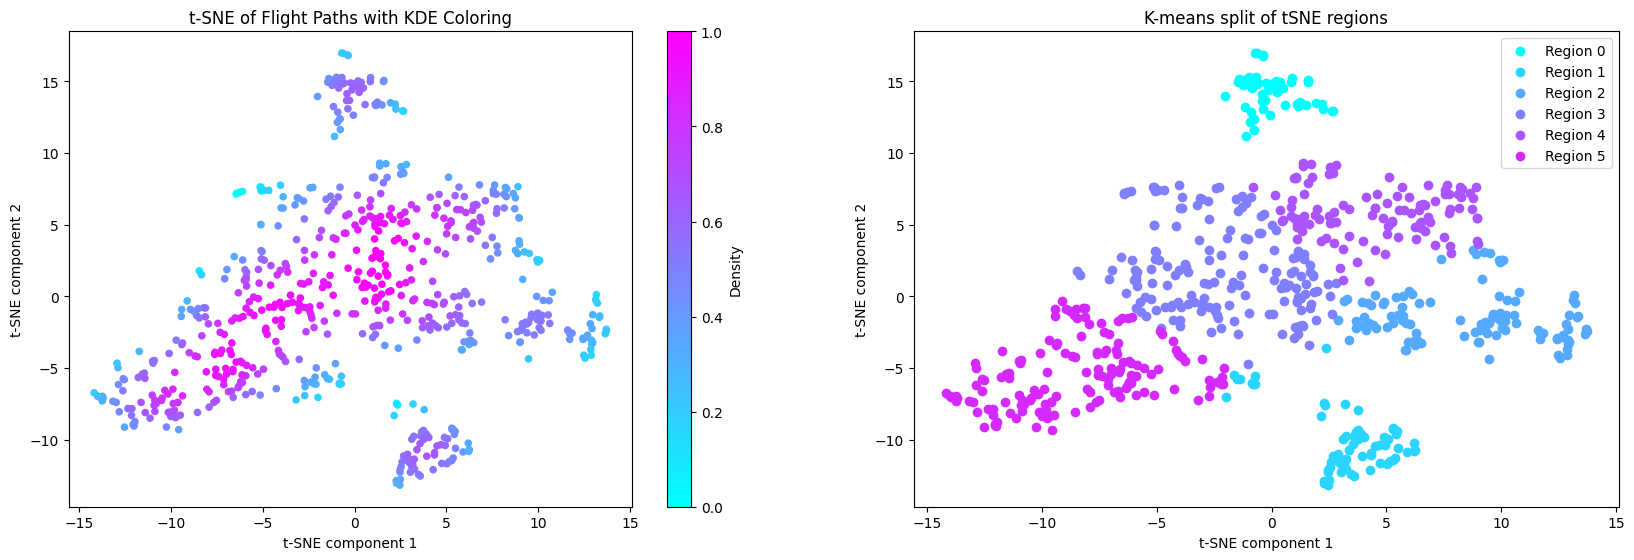

In [91]:
from sklearn.cluster import KMeans

n_clusters = 6  # You need to specify this
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
labels_kmeans = kmeans.fit_predict(tsne_results)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(ys)

# Compute the KDE values for each t-SNE point
kde = gaussian_kde(tsne_results.T)
density = kde(tsne_results.T)

# Normalize the density values to lie between 0 and 1
density_norm = (density - np.min(density)) / (np.max(density) - np.min(density))

fig, ax = plt.subplots(1, 2, figsize=[20, 10/1.62])

# Use the normalized density values to color each dot using the 'viridis' colormap (or any other of your choice)
sc = ax[0].scatter(tsne_results[:, 0], tsne_results[:, 1], c=density_norm, cmap=config['plotting']['cmap'], s=20)

# Add a colorbar to show the density scale
cbar = plt.colorbar(sc, ax=ax[0])
cbar.set_label('Density')

ax[0].set_xlabel('t-SNE component 1')
ax[0].set_ylabel('t-SNE component 2')
ax[0].set_title('t-SNE of Flight Paths with KDE Coloring')

for i, label in enumerate(np.unique(labels_kmeans)):
    mask = labels_kmeans == label
    color = colormap(float(i/n_clusters))
    ax[1].scatter(tsne_results[mask][:, 0],tsne_results[mask][:, 1], color=color, label = f'Region {i}')
ax[1].set_xlabel('t-SNE component 1')
ax[1].set_ylabel('t-SNE component 2')
ax[1].set_title('K-means split of tSNE regions')
ax[1].legend()
plt.close()
fig

In [22]:
# Find the minimum number of occurrences of any one kind of input
counts = [np.sum(xs[:, i]) for i in range(xs.shape[1])]
min_count = int(min(counts))
indices_for_each_type = [np.where(xs[:, i] == 1)[0] for i in range(xs.shape[1])]
sampled_indices = []

# Collect indices for each input type and then sample from them
for indices in indices_for_each_type:
    sampled_indices.extend(np.random.choice(indices, min_count, replace=False))

# Now, using the sampled indices, filter the input and output data
balanced_xs = xs[sampled_indices]
balanced_ys = ys[sampled_indices]


X_train, X_test, y_train, y_test = train_test_split(balanced_xs, balanced_ys, test_size=0.2, random_state=42)

In [23]:
n_airlines = xs.shape[1]
output_length = ys.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=n_airlines))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_length, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Specify the number of epochs and the batch size
epochs = 100
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=False)

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

2/2 [==============================] - 0s 3ms/step - loss: 180813.3125
Test Loss: 180813.3125


In [24]:
# Assuming new_data is a new piece of data you want to predict
predictions = model.predict(np.array([[1,0,0], [0,1,0], [0,0,1]]))
results = {airline:{col:np.repeat(0, timeseries_length) for col in columns} for airline in airlines}
for i, airline in enumerate(airlines):
    for j, col in enumerate(columns):
        results[airline][col] = predictions[i][j*timeseries_length : (j+1)*timeseries_length]
        results[airline]['total_time'] = predictions[i][-1]

1/1 [==============================] - 0s 63ms/step


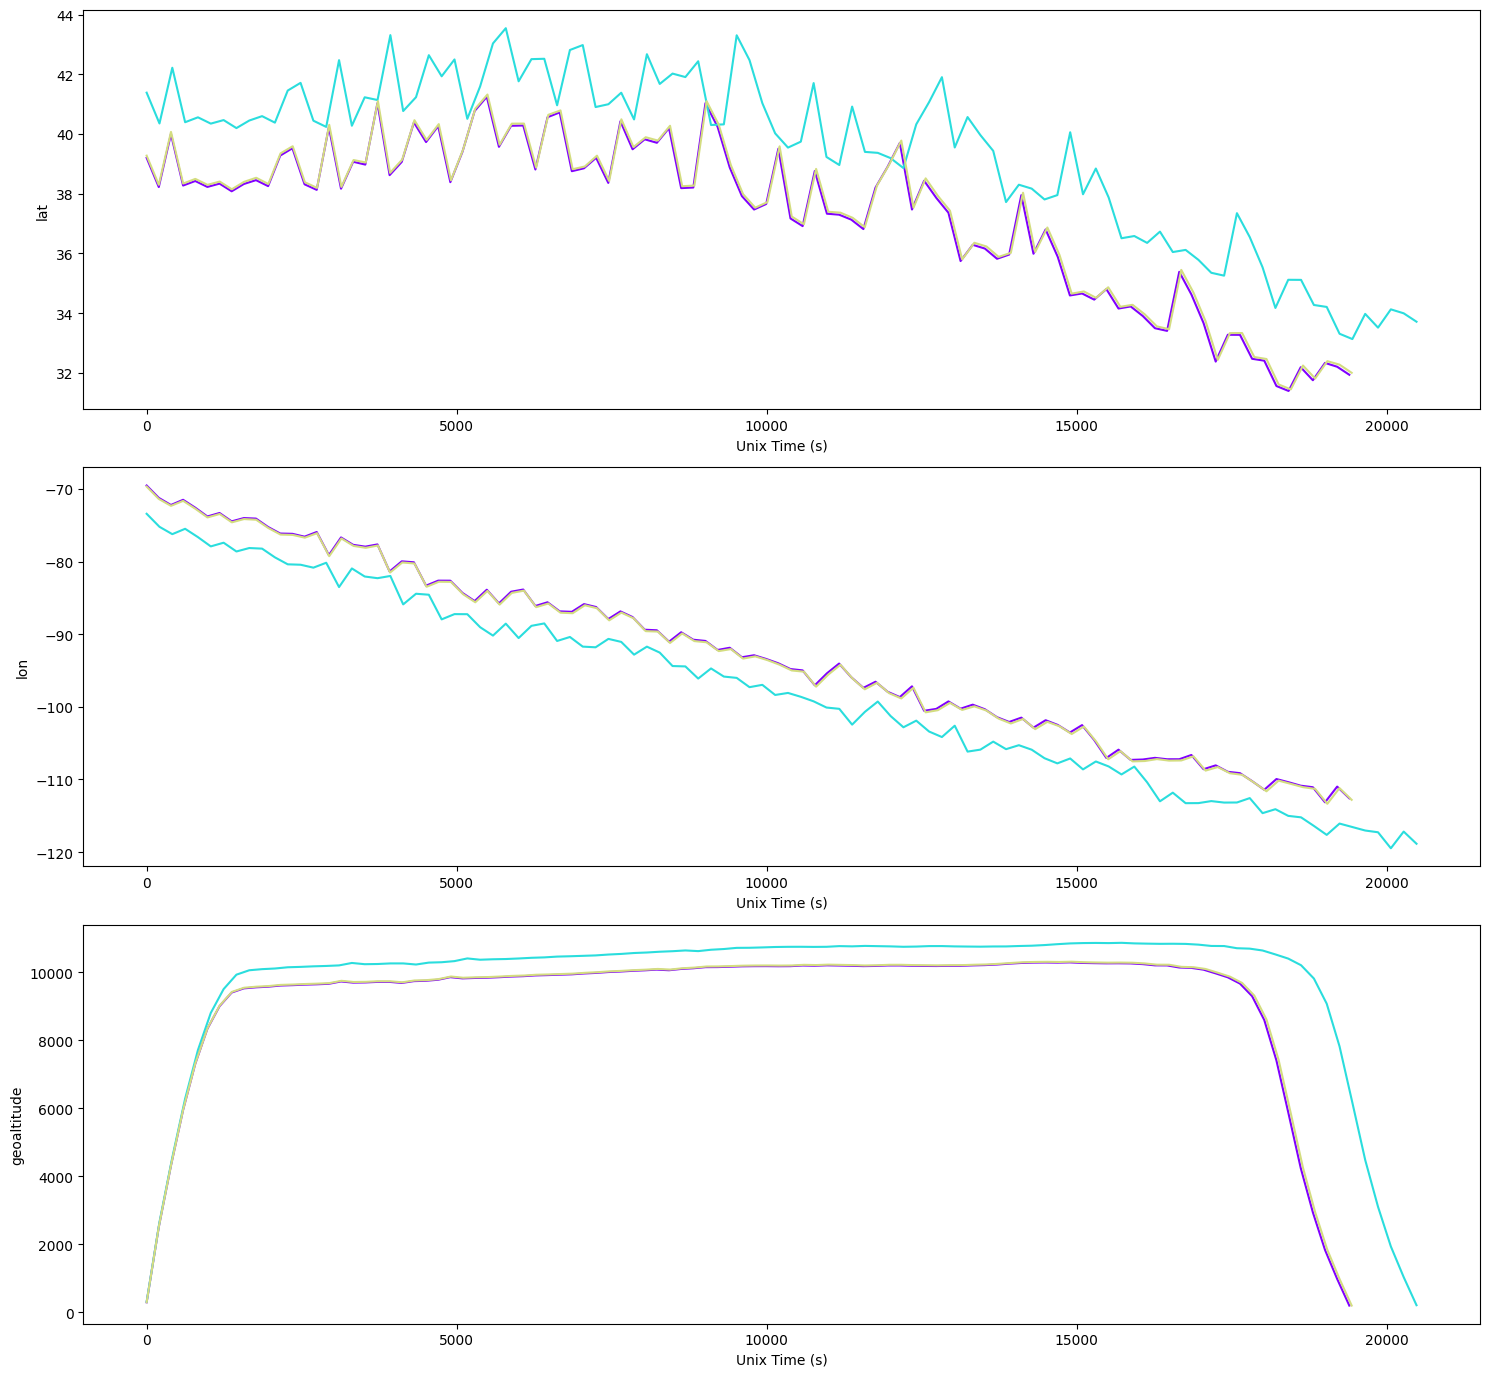

In [25]:
fig, ax = plt.subplots(len(columns), figsize = [15, 22.5/1.62])
for j, airline in enumerate(airlines):
    ts = np.linspace(0, results[airline]['total_time'], num = timeseries_length)
    for i, col in enumerate(columns):
        ax[i].plot(ts, results[airline][col], color = airline_colors[airline], label = airline)
        ax[i].set_xlabel('Unix Time (s)')
        ax[i].set_ylabel(f'{col}')      

fig.tight_layout()

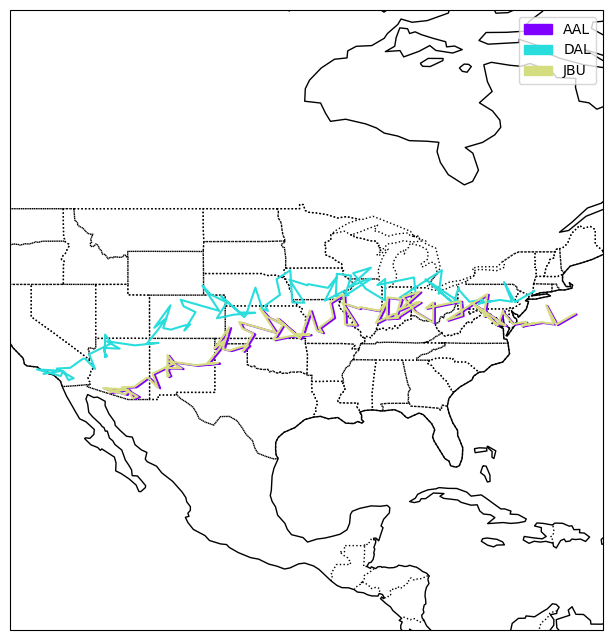

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = [6.5, 6.5])
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

for j, airline in enumerate(airlines):
    ax.plot(results[airline]['lon'], results[airline]['lat'], color=airline_colors[airline])

x_min, x_max, y_min, y_max = ax.get_extent()
RANGE = np.max([y_max - y_min, x_max - x_min])
y_mid = (y_max + y_min)/2
x_mid = (x_max + x_min)/2
ax.set_extent([x_mid - RANGE/2, x_mid + RANGE/2, y_mid - RANGE/2, y_mid + RANGE/2])

ax.legend(handles=legend_elements, loc='upper right')
fig.tight_layout()

In [ ]:
flights_info = {'Airline':[], 'WeekDayDept':[], }